Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Time step convergence tests towards implementing P3M gravity

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH + "results/"
output_path = OUTPUT_PATH

# Simulation parameters—they all give interesting insights
# L = 128  # Box size in Mpc/h
# L = 64  # Box size in Mpc/h
L = 32  # Box size in Mpc/h
# L = 16  # Box size in Mpc/h
# L = 8  # Box size in Mpc/h
N = 32  # Density grid size
Np = 32  # Number of dark matter particles per spatial dimension
Npm = 64  # PM grid size
n_Tiles = 8

go_beyond_Nyquist_ss = True  # for the summary statistics

force = True
force_hard = True

run_id = "notebook2"

# Fast force diagnostic
force_diagnostic = False
nPairsForceDiagnostic = 3
nBinsForceDiagnostic = 20
maxTrialsForceDiagnostic = int(1e8)

# Simulation parameters
nsteps_pmref = 200
nsteps_pm1 = 100
nsteps_pm2 = 50
nsteps_cola = 20
nsteps_spm = nsteps_p3m1 = 300
nsteps_p3m2 = 200
nsteps_p3m3 = 50

TimeStepDistribution_pmref = 0
TimeStepDistribution_pm1 = 0
TimeStepDistribution_pm2 = 0
TimeStepDistribution_cola = 0
TimeStepDistribution_spm = 0
TimeStepDistribution_p3m1 = 0
TimeStepDistribution_p3m2 = 0
TimeStepDistribution_p3m3 = 0

In principle nothing needs to be changed below this cell.

In [3]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.fft import FourierGrid, read_FourierGrid
from pysbmy.field import read_field
from pysbmy.correlations import get_autocorrelation

from wip3m.tools import get_k_max, generate_sim_params, generate_white_noise_Field, run_simulation
from wip3m.params import params_planck_kmax_missing, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE
from wip3m.plot_utils import *  # type: ignore

In [4]:
corner = -L / 2.0
RedshiftLPT = 19.0
RedshiftFCs = 0.0
ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)
k_max = get_k_max(L, N)  # k_max in h/Mpc
print(f"k_max = {k_max}")
cosmo = params_planck_kmax_missing.copy()
cosmo["k_max"] = k_max

wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
logdir = simdir + "logs/"
if force_hard:
    import shutil
    if Path(simdir).exists():
        shutil.rmtree(simdir)
    if Path(wd).exists():
        shutil.rmtree(wd)
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

sim_params = {
    "L": L,
    "N": N,
    "Np": Np,
    "Npm": Npm,
    "n_Tiles": n_Tiles,
    "RedshiftLPT": RedshiftLPT,
    "RedshiftFCs": RedshiftFCs,
}
with open(wd + "sim_params.txt", "w") as f:
    f.write(f"{sim_params}\n")

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

# Paths the the force diagnostic CSVs
OutputForceDiagnostic_pmref = simdir + "force_diagnostic_pmref.txt"
OutputForceDiagnostic_pm1 = simdir + "force_diagnostic_pm1.txt"
OutputForceDiagnostic_pm2 = simdir + "force_diagnostic_pm2.txt"
OutputForceDiagnostic_cola = simdir + "force_diagnostic_cola.txt"
OutputForceDiagnostic_spm = simdir + "force_diagnostic_spm.txt"
OutputForceDiagnostic_p3m1 = simdir + "force_diagnostic_p3m1.txt"
OutputForceDiagnostic_p3m2 = simdir + "force_diagnostic_p3m2.txt"
OutputForceDiagnostic_p3m3 = simdir + "force_diagnostic_p3m3.txt"

k_max = 5.442


### Generate the parameter files

The first preparatory step is to generate all the parameter files required for all the simulations.

To this end we use the `generate_sim_params` function defined in `params.py`.

In [5]:
common_params = {
    "Np": Np,
    "N": N,
    "L": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
lpt_params["InputWhiteNoise"] = input_white_noise_file

common_params_num = common_params.copy()
common_params_num["ai"] = ai
common_params_num["af"] = af
common_params_num["RedshiftLPT"] = RedshiftLPT
common_params_num["RedshiftFCs"] = RedshiftFCs
common_params_num["Npm"] = Npm
common_params_num["RunForceDiagnostic"] = force_diagnostic
common_params_num["nBinsForceDiagnostic"] = nBinsForceDiagnostic
common_params_num["nPairsForceDiagnostic"] = nPairsForceDiagnostic
common_params_num["maxTrialsForceDiagnostic"] = maxTrialsForceDiagnostic

pmref_params = common_params_num.copy()
pmref_params["method"] = "pm"
pmref_params["TimeStepDistribution"] = TimeStepDistribution_pmref
pmref_params["nsteps"] = nsteps_pmref
pmref_params["OutputForceDiagnostic"] = OutputForceDiagnostic_pmref

pm1_params = common_params_num.copy()
pm1_params["method"] = "pm"
pm1_params["TimeStepDistribution"] = TimeStepDistribution_pm1
pm1_params["nsteps"] = nsteps_pm1
pm1_params["OutputForceDiagnostic"] = OutputForceDiagnostic_pm1

pm2_params = common_params_num.copy()
pm2_params["method"] = "pm"
pm2_params["TimeStepDistribution"] = TimeStepDistribution_pm2
pm2_params["nsteps"] = nsteps_pm2
pm2_params["OutputForceDiagnostic"] = OutputForceDiagnostic_pm2

cola_params = common_params_num.copy()
cola_params["method"] = "cola"
cola_params["TimeStepDistribution"] = TimeStepDistribution_cola
cola_params["nsteps"] = nsteps_cola
cola_params["OutputForceDiagnostic"] = OutputForceDiagnostic_cola

spm_params = common_params_num.copy()
spm_params["method"] = "spm"
spm_params["EvolutionMode"] = 5
spm_params["TimeStepDistribution"] = TimeStepDistribution_spm
spm_params["nsteps"] = nsteps_spm
spm_params["n_Tiles"] = n_Tiles
spm_params["OutputForceDiagnostic"] = OutputForceDiagnostic_spm

p3m1_params = common_params_num.copy()
p3m1_params["method"] = "p3m"
p3m1_params["EvolutionMode"] = 4
p3m1_params["TimeStepDistribution"] = TimeStepDistribution_p3m1
p3m1_params["nsteps"] = nsteps_p3m1
p3m1_params["n_Tiles"] = n_Tiles
p3m1_params["OutputForceDiagnostic"] = OutputForceDiagnostic_p3m1

p3m2_params = common_params_num.copy()
p3m2_params["method"] = "p3m"
p3m2_params["EvolutionMode"] = 4
p3m2_params["TimeStepDistribution"] = TimeStepDistribution_p3m2
p3m2_params["nsteps"] = nsteps_p3m2
p3m2_params["n_Tiles"] = n_Tiles
p3m2_params["OutputForceDiagnostic"] = OutputForceDiagnostic_p3m2

p3m3_params = common_params_num.copy()
p3m3_params["method"] = "p3m"
p3m3_params["EvolutionMode"] = 4
p3m3_params["TimeStepDistribution"] = TimeStepDistribution_p3m3
p3m3_params["nsteps"] = nsteps_p3m3
p3m3_params["n_Tiles"] = n_Tiles
p3m3_params["OutputForceDiagnostic"] = OutputForceDiagnostic_p3m3

[09:21:47|INFO      ]|(wip3m.tools) Generating parameter file...
[09:21:47|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook2/example_lpt.sbmy'...
[09:21:47|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook2/example_lpt.sbmy' done.
[09:21:47|INFO      ]|(wip3m.tools) Parameter file written to /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook2/example_lpt.sbmy
PMREF nsteps = 200:
[09:21:47|INFO      ]|(wip3m.tools) Time-stepping distribution file: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook2/pmref_nsteps200_ts_pm.h5
[09:21:47|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/Library/CloudStora

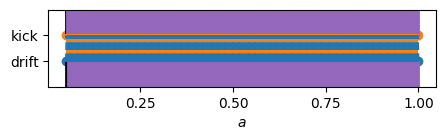

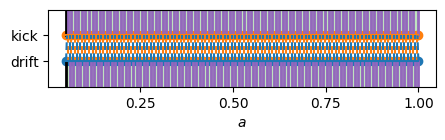

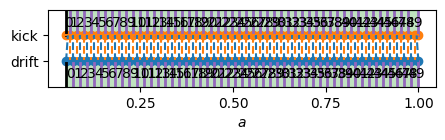

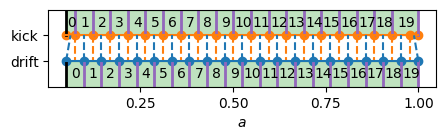

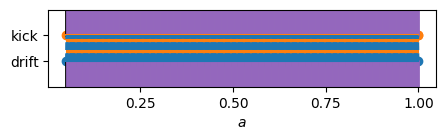

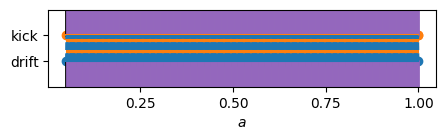

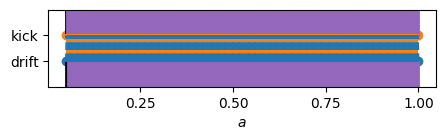

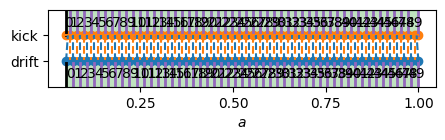

In [6]:
reset_plotting()  # Default style for Simbelmynë
generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)

all_sim_params = [
    ("pmref", pmref_params),
    ("pm1", pm1_params),
    ("pm2", pm2_params),
    ("cola", cola_params),
    ("spm", spm_params),
    ("p3m1", p3m1_params),
    ("p3m2", p3m2_params),
    ("p3m3", p3m3_params),
]
for name, params in all_sim_params:
    print(f"{name.upper()} nsteps = {params['nsteps']}:")
    file_ext = f"{name}_nsteps{params['nsteps']}"
    generate_sim_params(params, ICs_path, wd, simdir, file_ext, force)

setup_plotting()  # Reset plotting style for this project

### Generate the initial phase

In [7]:
generate_white_noise_Field(
    L=L,
    size=N,
    corner=corner,
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    force_phase=force,
)

### Generating the input power spectrum

The second preparatory step is to compute the initial power spectrum to be used in the simulations, given the cosmological parameters and prescription specified in ``params.py``. The power spectrum is saved in `input_power_file`.

In [8]:
# If cosmo["WhichSpectrum"] == "class", then classy is required.
if not isfile(input_power_file) or force:
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[09:21:55|STATUS    ]|Setting up Fourier grid...
[09:21:55|STATUS    ]|Setting up Fourier grid done.
[09:21:55|STATUS    ]|Computing normalization of the power spectrum...
[09:21:55|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook2/input_power.h5'...
[09:21:55|STATUS    ]|Computing normalization of the power spectrum done.
[09:21:55|STATUS    ]|Computing power spectrum...
[09:21:55|STATUS    ]|Computing power spectrum done.
[09:21:55|DIAGNOSTIC]==|L0=32, L1=32, L2=32
[09:21:55|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=464
[09:21:55|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook2/input_power.h5' done.


In [9]:
# k grid used to compute the final overdensity power spectrum
Pinit = 100
trim_threshold = 100  # Merge bins until this minimum number of modes per bin is reached
log_kmin = np.log10(2 * np.pi / (np.sqrt(3) * L))  # Minimum non-zero k in h/Mpc
if go_beyond_Nyquist_ss:
    k_max_ss = get_k_max(L, N)
else:
    k_max_ss = get_k_max(L, N) / np.sqrt(3)  # 1D Nyquist frequency
Pbins_left_bnds = np.logspace(log_kmin, np.log10(k_max_ss), Pinit + 1, dtype=np.float32)
Pbins_left_bnds = Pbins_left_bnds[:-1]
input_ss_file = simdir + "input_ss_k_grid.h5"
Gk = FourierGrid(
    L,
    L,
    L,
    N,
    N,
    N,
    k_modes=Pbins_left_bnds,
    kmax=k_max_ss,
    trim_bins=True,
    trim_threshold=trim_threshold,
)
Gk.write(input_ss_file)

[09:21:55|STATUS    ]|Setting up Fourier grid...
[09:21:55|STATUS    ]|Setting up Fourier grid done.
[09:21:55|STATUS    ]|Write Fourier grid in data file '/Users/hoellinger/WIP3M/notebook2/input_ss_k_grid.h5'...
[09:21:55|DIAGNOSTIC]==|L0=32, L1=32, L2=32
[09:21:55|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=40
[09:21:55|STATUS    ]|Write Fourier grid in data file '/Users/hoellinger/WIP3M/notebook2/input_ss_k_grid.h5' done.


## Running the simulations

We are now ready to run the actual simulations using the Simbelmynë executable. Warning: the following may take some time, even in relatively low dimension, and should not be run on a login node.

In [10]:
run_simulation("lpt", lpt_params, wd, logdir)

[09:21:55|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook2/example_lpt.sbmy /Users/hoellinger/WIP3M/notebook2/logs/lpt.txt
[09:21:55|INFO      ]|
[09:21:55|INFO      ]|            .-~~-.--.
[09:21:55|INFO      ]|           :         )
[09:21:55|INFO      ]|     .~ ~ -.\       /.- ~~ .
[09:21:55|INFO      ]|     >       `.   .'       <
[09:21:55|INFO      ]|    (         .- -.         )
[09:21:55|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[09:21:55|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[09:21:55|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[09:21:55|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[09:21:55|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[09:21:55|INFO      ]|       

In [11]:
for name, params in all_sim_params:
    run_simulation(name, params, wd, logdir)

[09:21:56|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook2/pmref_nsteps200_example_pm.sbmy /Users/hoellinger/WIP3M/notebook2/logs/pmref_nsteps200pm.txt
[09:21:56|INFO      ]|
[09:21:56|INFO      ]|            .-~~-.--.
[09:21:56|INFO      ]|           :         )
[09:21:56|INFO      ]|     .~ ~ -.\       /.- ~~ .
[09:21:56|INFO      ]|     >       `.   .'       <
[09:21:56|INFO      ]|    (         .- -.         )
[09:21:56|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[09:21:56|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[09:21:56|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[09:21:56|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[09:21:56|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________


The logs can be monitored in the corresponding files in the `logdir` directory.

## Plot results

### Plot the evolved dark matter density fields

In [12]:
slice_ijk = (N // 2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]
DELTA_PMREF = read_field(simdir + f"pmref_nsteps{nsteps_pmref}_final_density_pm.h5").data[slice_ijk]
DELTA_PM1 = read_field(simdir + f"pm1_nsteps{nsteps_pm1}_final_density_pm.h5").data[slice_ijk]
DELTA_PM2 = read_field(simdir + f"pm2_nsteps{nsteps_pm2}_final_density_pm.h5").data[slice_ijk]
DELTA_COLA = read_field(simdir + f"cola_nsteps{nsteps_cola}_final_density_cola.h5").data[slice_ijk]
DELTA_SPM = read_field(simdir + f"spm_nsteps{nsteps_spm}_final_density_spm.h5").data[slice_ijk]
DELTA_P3M1 = read_field(simdir + f"p3m1_nsteps{nsteps_p3m1}_final_density_p3m.h5").data[slice_ijk]
DELTA_P3M2 = read_field(simdir + f"p3m2_nsteps{nsteps_p3m2}_final_density_p3m.h5").data[slice_ijk]
DELTA_P3M3 = read_field(simdir + f"p3m3_nsteps{nsteps_p3m3}_final_density_p3m.h5").data[slice_ijk]
diff_pm1_pmref = DELTA_PM1 - DELTA_PMREF
diff_pm2_pmref = DELTA_PM2 - DELTA_PMREF
diff_p3m1_pmref = DELTA_P3M1 - DELTA_PMREF
diff_p3m2_pm1 = DELTA_P3M2 - DELTA_PM1
diff_p3m3_pm2 = DELTA_P3M3 - DELTA_PM2
diff_p3m1_spm = DELTA_P3M1 - DELTA_SPM

[09:23:14|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/lpt_density.h5'...
[09:23:14|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.int32(32), np.int32(32), np.int32(32)]
[09:23:14|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/lpt_density.h5' done.
[09:23:14|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/pmref_nsteps200_final_density_pm.h5'...
[09:23:14|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.int32(32), np.int32(32), np.int32(32)]
[09:23:14|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/pmref_nsteps200_final_density_pm.h5' done.
[09:23:14|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/pm1_nsteps100_final_density_pm.h5'...
[09:23:14|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(1

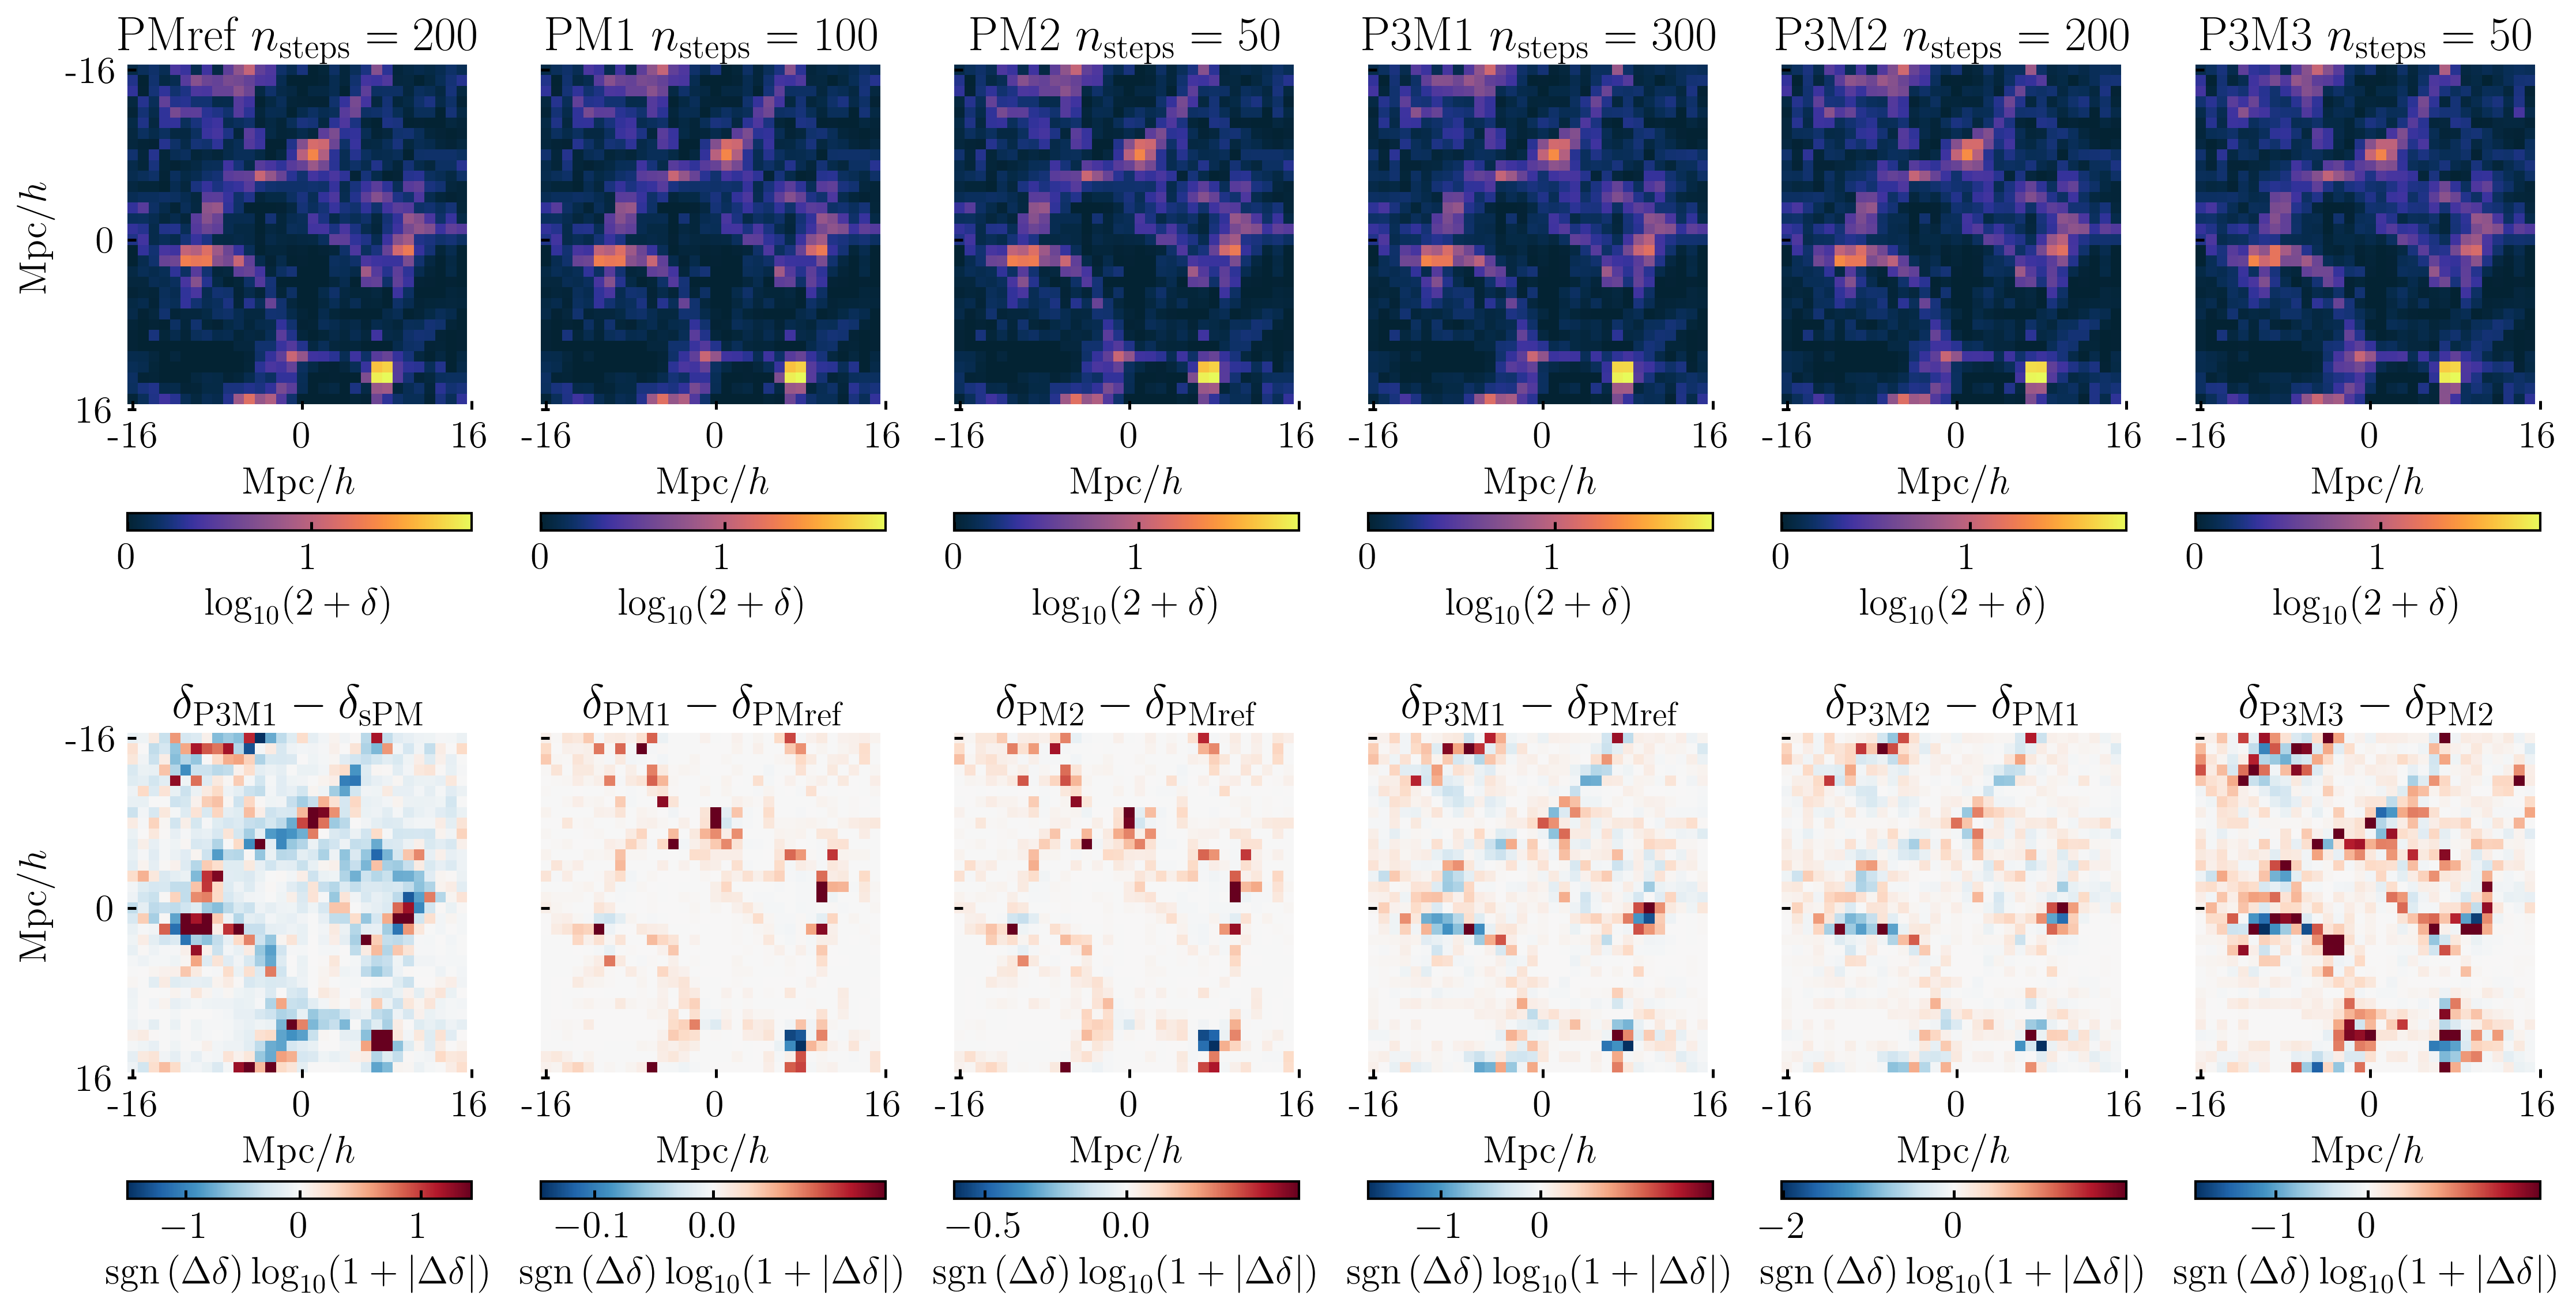

In [13]:
fields = ["pmref", "pm1", "pm2", "p3m1", "p3m2", "p3m3", "diff_p3m1_spm", "diff_pm1_pmref", "diff_pm2_pmref", "diff_p3m1_pmref", "diff_p3m2_pm1", "diff_p3m3_pm2"]  # fields to plot
# fields = ["lpt", "pmref", "pm1", "pm2", "cola", "spm", "p3m1", "p3m2", "p3m3", "diff_p3m1_spm", "diff_pm1_pmref", "diff_pm2_pmref", "diff_p3m1_pmref", "diff_p3m2_pm1", "diff_p3m3_pm2"]  # fields to plot

figname = "_".join(fields)
slices_dict = {
    "lpt": DELTA_LPT,
    "cola": DELTA_COLA,
    "pmref": DELTA_PMREF,
    "pm1": DELTA_PM1,
    "pm2": DELTA_PM2,
    "spm": DELTA_SPM,
    "p3m1": DELTA_P3M1,
    "p3m2": DELTA_P3M2,
    "p3m3": DELTA_P3M3,
    "diff_pm1_pmref": diff_pm1_pmref,
    "diff_pm2_pmref": diff_pm2_pmref,
    "diff_p3m1_pmref": diff_p3m1_pmref,
    "diff_p3m2_pm1": diff_p3m2_pm1,
    "diff_p3m3_pm2": diff_p3m3_pm2,
    "diff_p3m1_spm": diff_p3m1_spm,
}
titles_dict = {
    "lpt": "LPT",
    "pmref": f"PMref $n_\\mathrm{{steps}}={nsteps_pmref}$",
    "pm1": f"PM1 $n_\\mathrm{{steps}}={nsteps_pm1}$",
    "pm2": f"PM2 $n_\\mathrm{{steps}}={nsteps_pm2}$",
    "cola": f"COLA $n_\\mathrm{{steps}}={nsteps_cola}$",
    "spm": f"sPM $n_\\mathrm{{steps}}={nsteps_spm}$",
    "p3m1": f"P3M1 $n_\\mathrm{{steps}}={nsteps_p3m1}$",
    "p3m2": f"P3M2 $n_\\mathrm{{steps}}={nsteps_p3m2}$",
    "p3m3": f"P3M3 $n_\\mathrm{{steps}}={nsteps_p3m3}$",
    "diff_pm1_pmref": r"$\delta_{\rm PM1}-\delta_{\rm PMref}$",
    "diff_pm2_pmref": r"$\delta_{\rm PM2}-\delta_{\rm PMref}$",
    "diff_p3m1_pmref": r"$\delta_{\rm P3M1}-\delta_{\rm PMref}$",
    "diff_p3m2_pm1": r"$\delta_{\rm P3M2}-\delta_{\rm PM1}$",
    "diff_p3m3_pm2": r"$\delta_{\rm P3M3}-\delta_{\rm PM2}$",
    "diff_p3m1_spm": r"$\delta_{\rm P3M1}-\delta_{\rm sPM}$",
}

ncols = 6  # Max panels per row
npanels = len(fields)
nrows = np.ceil(npanels / ncols).astype(int)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(3 * ncols, 4.6 * nrows), sharey=True
)

axs = axs.flatten()
ims = []

for i, key in enumerate(fields):
    ax = axs[i]
    data = slices_dict[key]
    title = titles_dict[key]

    if key.startswith("diff"):
        norm = TwoSlopeNorm(
            vmin=-np.log(1 + np.abs(np.min(data))),
            vcenter=0,
            vmax=np.log10(1 + np.abs(np.max(data))),
        )
        im = ax.imshow(
            np.sign(data) * np.log(1 + np.abs(data)), cmap="RdBu_r", norm=norm
        )
    else:
        im = ax.imshow(np.log10(2 + data), cmap=cmap)

    ims.append((im, key))
    ax.set_title(title, fontsize=fs_titles)
    for spine in ax.spines.values():
        spine.set_visible(False)

# Hide unused axes
for i in range(npanels, len(axs)):
    axs[i].axis("off")

# Shared axes labels
for i, ax in enumerate(axs[:npanels]):
    if i % ncols == 0:
        ax.set_yticks([0, N // 2, N])
        ax.set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
        ax.set_ylabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
    ax.set_xlabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

# Colorbars
for ax, (im, key) in zip(axs[:npanels], ims):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    if key.startswith("diff"):
        cb.set_label(
            r"$\textrm{sgn}\left(\Delta\delta\right)\log_{10}(1 + |\Delta\delta|)$",
            fontsize=fs,
        )
    else:
        cb.set_label(r"$\log_{10}(2 + \delta)$", fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    cax.xaxis.set_ticks_position("bottom")
    cax.xaxis.set_label_position("bottom")

fig.savefig(simdir + f"{figname}.png", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(simdir + f"{figname}.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [14]:
full_field_p3m1 = np.log10(2+read_field(simdir + f"p3m1_nsteps{nsteps_p3m1}_final_density_p3m.h5").data)

if N <= 128:
    fig = plotly_3d(full_field_p3m1, size=N, L=L, colormap=thermal_plotly, limits="default")
else:
    # Downsample the grid for visualisation
    downsample_factor = N // 128
    downsampled_field = full_field_p3m1[
        ::downsample_factor, ::downsample_factor, ::downsample_factor
    ]
    fig = plotly_3d(downsampled_field, size=N, L=L, colormap=thermal_plotly, limits="default")

fig.show()
clear_large_plot(fig)  # Uncomment to clear the Plotly figure to avoid memory issues

### Compute and plot the power spectra of the evolved dark matter fields

In [15]:
G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes[1:]
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

DELTA = read_field(simdir + f"pmref_nsteps{nsteps_pmref}_final_density_pm.h5")
Pk_PMref, Vk_PMref = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_PMref, Vk_PMref = Pk_PMref[1:], Vk_PMref[1:]
Sk_PMref = np.sqrt(Vk_PMref)

DELTA = read_field(simdir + f"pm1_nsteps{nsteps_pm1}_final_density_pm.h5")
Pk_PM1, Vk_PM1 = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_PM1, Vk_PM1 = Pk_PM1[1:], Vk_PM1[1:]
Sk_PM1 = np.sqrt(Vk_PM1)

DELTA = read_field(simdir + f"pm2_nsteps{nsteps_pm2}_final_density_pm.h5")
Pk_PM2, Vk_PM2 = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_PM2, Vk_PM2 = Pk_PM2[1:], Vk_PM2[1:]
Sk_PM2 = np.sqrt(Vk_PM2)

DELTA = read_field(simdir + f"cola_nsteps{nsteps_cola}_final_density_cola.h5")
Pk_COLA, Vk_COLA = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_COLA, Vk_COLA = Pk_COLA[1:], Vk_COLA[1:]
Sk_COLA = np.sqrt(Vk_COLA)

DELTA = read_field(simdir + f"spm_nsteps{nsteps_spm}_final_density_spm.h5")
Pk_sPM, Vk_sPM = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_sPM, Vk_sPM = Pk_sPM[1:], Vk_sPM[1:]
Sk_sPM = np.sqrt(Vk_sPM)

DELTA = read_field(simdir + f"p3m1_nsteps{nsteps_p3m1}_final_density_p3m.h5")
Pk_P3M1, Vk_P3M1 = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_P3M1, Vk_P3M1 = Pk_P3M1[1:], Vk_P3M1[1:]
Sk_P3M1 = np.sqrt(Vk_P3M1)

DELTA = read_field(simdir + f"p3m2_nsteps{nsteps_p3m2}_final_density_p3m.h5")
Pk_P3M2, Vk_P3M2 = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_P3M2, Vk_P3M2 = Pk_P3M2[1:], Vk_P3M2[1:]
Sk_P3M2 = np.sqrt(Vk_P3M2)

DELTA = read_field(simdir + f"p3m3_nsteps{nsteps_p3m3}_final_density_p3m.h5")
Pk_P3M3, Vk_P3M3 = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_P3M3, Vk_P3M3 = Pk_P3M3[1:], Vk_P3M3[1:]
Sk_P3M3 = np.sqrt(Vk_P3M3)

[09:23:17|STATUS    ]|Read Fourier grid in data file '/Users/hoellinger/WIP3M/notebook2/input_ss_k_grid.h5'...
[09:23:17|DIAGNOSTIC]==|L0=32.0, L1=32.0, L2=32.0
[09:23:17|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=40
[09:23:17|STATUS    ]|Read Fourier grid in data file '/Users/hoellinger/WIP3M/notebook2/input_ss_k_grid.h5' done.
[09:23:17|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/initial_density.h5'...
[09:23:17|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.int32(32), np.int32(32), np.int32(32)]
[09:23:17|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/initial_density.h5' done.
[09:23:17|STATUS    ]|Getting auto-correlation in Fourier space (using 8 cores)...
[09:23:17|[09:23:17|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook2/lpt_density.h5'...
STATUS    ]|Getting auto-correlation in Fourier space (u

kmin = 0.6727633476257324, kmax = 5.036545276641846
Nyquist (density grid): 3.14 h/Mpc
Nyquist (PM grid): 6.28 h/Mpc
Particle wavenumber: 104.72 h/Mpc
Split wavenumber: 10.05 h/Mpc
Short-range reach: 2.23 h/Mpc


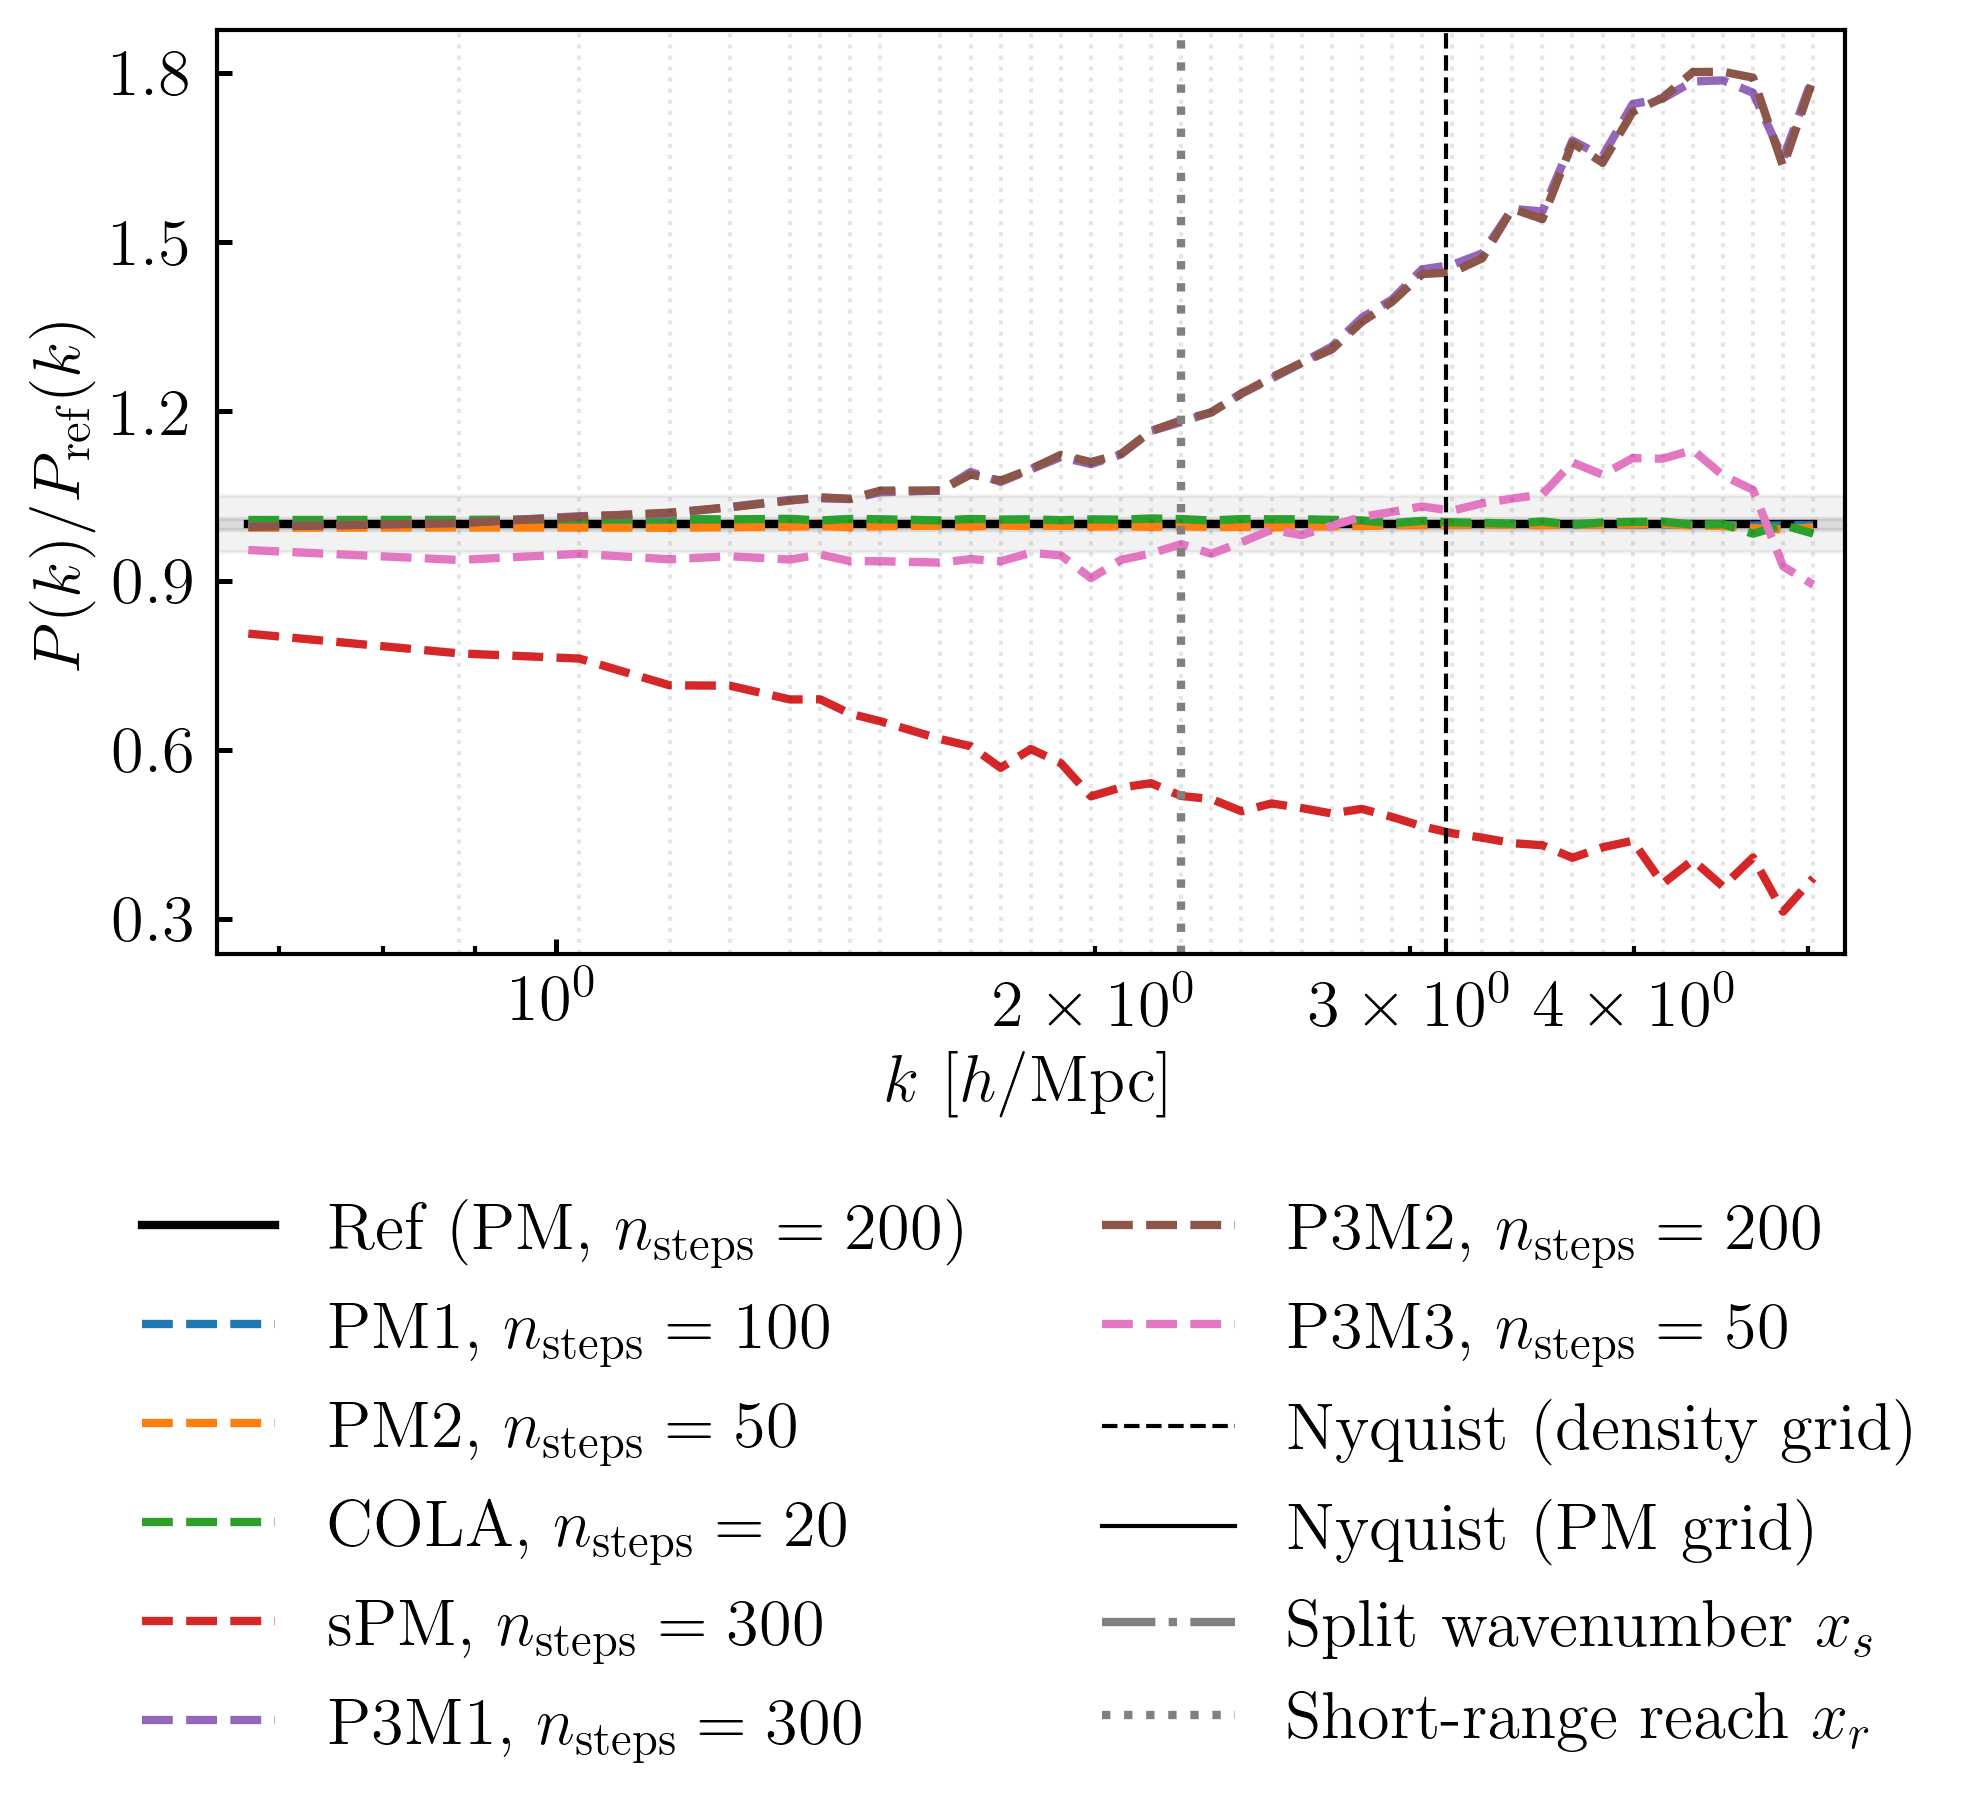

In [16]:
Pk_ref = Pk_PMref

fig, ax = plt.subplots(figsize=(7, 4))

ax.set_xscale("log")
k = G.k_modes[1:]
kmin, kmax = k.min(), k.max()
print(f"kmin = {kmin}, kmax = {kmax}")
log_pad = 0.02
log_k_min = np.log10(kmin)
log_k_max = np.log10(kmax)
log_range = log_k_max - log_k_min
xlim_min = 10 ** (log_k_min - log_pad * log_range)
xlim_max = 10 ** (log_k_max + log_pad * log_range)

plt.xlim(xlim_min, xlim_max)
# ax.set_ylim([0.2, 1.8])
dark_grey_bnd = 0.01
light_grey_bnd = 0.05

label_ref = f"Ref (PM, $n_\\mathrm{{steps}}={nsteps_pmref}$)"

ax.plot([kmin, kmax], [1, 1], color="black", linestyle="-", label=label_ref)
# ax.plot(k, Pk_LPT / Pk_ref, label="2LPT", linestyle="--")
fields_to_plot = [
    ("PM1", Pk_PM1),
    ("PM2", Pk_PM2),
    ("COLA", Pk_COLA),
    ("sPM", Pk_sPM),
    ("P3M1", Pk_P3M1),
    ("P3M2", Pk_P3M2),
    ("P3M3", Pk_P3M3),
]
for field_name, Pk in fields_to_plot:
    label = f"{field_name}, $n_\\mathrm{{steps}}={eval(f'nsteps_{field_name.lower()}')}$"
    ax.plot(k, Pk / Pk_ref, label=label, linestyle="--")

ax.axhspan(1 - dark_grey_bnd, 1 + dark_grey_bnd, color="grey", alpha=0.2)
ax.axhspan(1 - light_grey_bnd, 1 + light_grey_bnd, color="grey", alpha=0.1)

for i in range(1, len(k)):
    ax.axvline(k[i], color="black", linestyle=":", linewidth=1, alpha=0.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)

# Characteristic vertical reference scales
nyquist = np.pi * N / L
nyquist_PM = np.pi * Npm / L
epsilon = 0.03 * L / Np
particle_length = 2*epsilon
xs = 1.25 * L / Npm
xr = 4.5 * xs
particle_wavenumber = 2*np.pi / particle_length
xs_inv = 2*np.pi / xs
xr_inv = 2*np.pi / xr
line1 = ax.axvline(x=nyquist, color="black", linestyle="--", lw=1, label="Nyquist (density grid)")
line1 = ax.axvline(x=nyquist_PM, color="black", linestyle="-", lw=1, label="Nyquist (PM grid)")
# line2 = ax.axvline(x=particle_wavenumber, color="gray", linestyle="--", lw=2, label=r"Particle wavenumber $2\epsilon$")
line3 = ax.axvline(x=xs_inv, color="gray", linestyle="-.", lw=2, label=r"Split wavenumber $x_s$")
line4 = ax.axvline(x=xr_inv, color="gray", linestyle=":", lw=2, label=r"Short-range reach $x_r$")
print(f"Nyquist (density grid): {nyquist:.2f} h/Mpc")
print(f"Nyquist (PM grid): {nyquist_PM:.2f} h/Mpc")
print(f"Particle wavenumber: {particle_wavenumber:.2f} h/Mpc")
print(f"Split wavenumber: {xs_inv:.2f} h/Mpc")
print(f"Short-range reach: {xr_inv:.2f} h/Mpc")

empty_patch = mpatches.Patch(color="none", label="")
handles, labels = plt.gca().get_legend_handles_labels()
# handles = [empty_patch, *handles]
# labels = ["", *labels]
plt.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.2),
    fontsize=fs,
    frameon=False,
)
fig.savefig(
    simdir + "power_spectra.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + "power_spectra.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

kmin = 0.6727633476257324, kmax = 5.036545276641846
Nyquist (density grid): 3.14 h/Mpc
Nyquist (PM grid): 6.28 h/Mpc
Particle wavenumber: 104.72 h/Mpc
Split wavenumber: 10.05 h/Mpc
Short-range reach: 2.23 h/Mpc


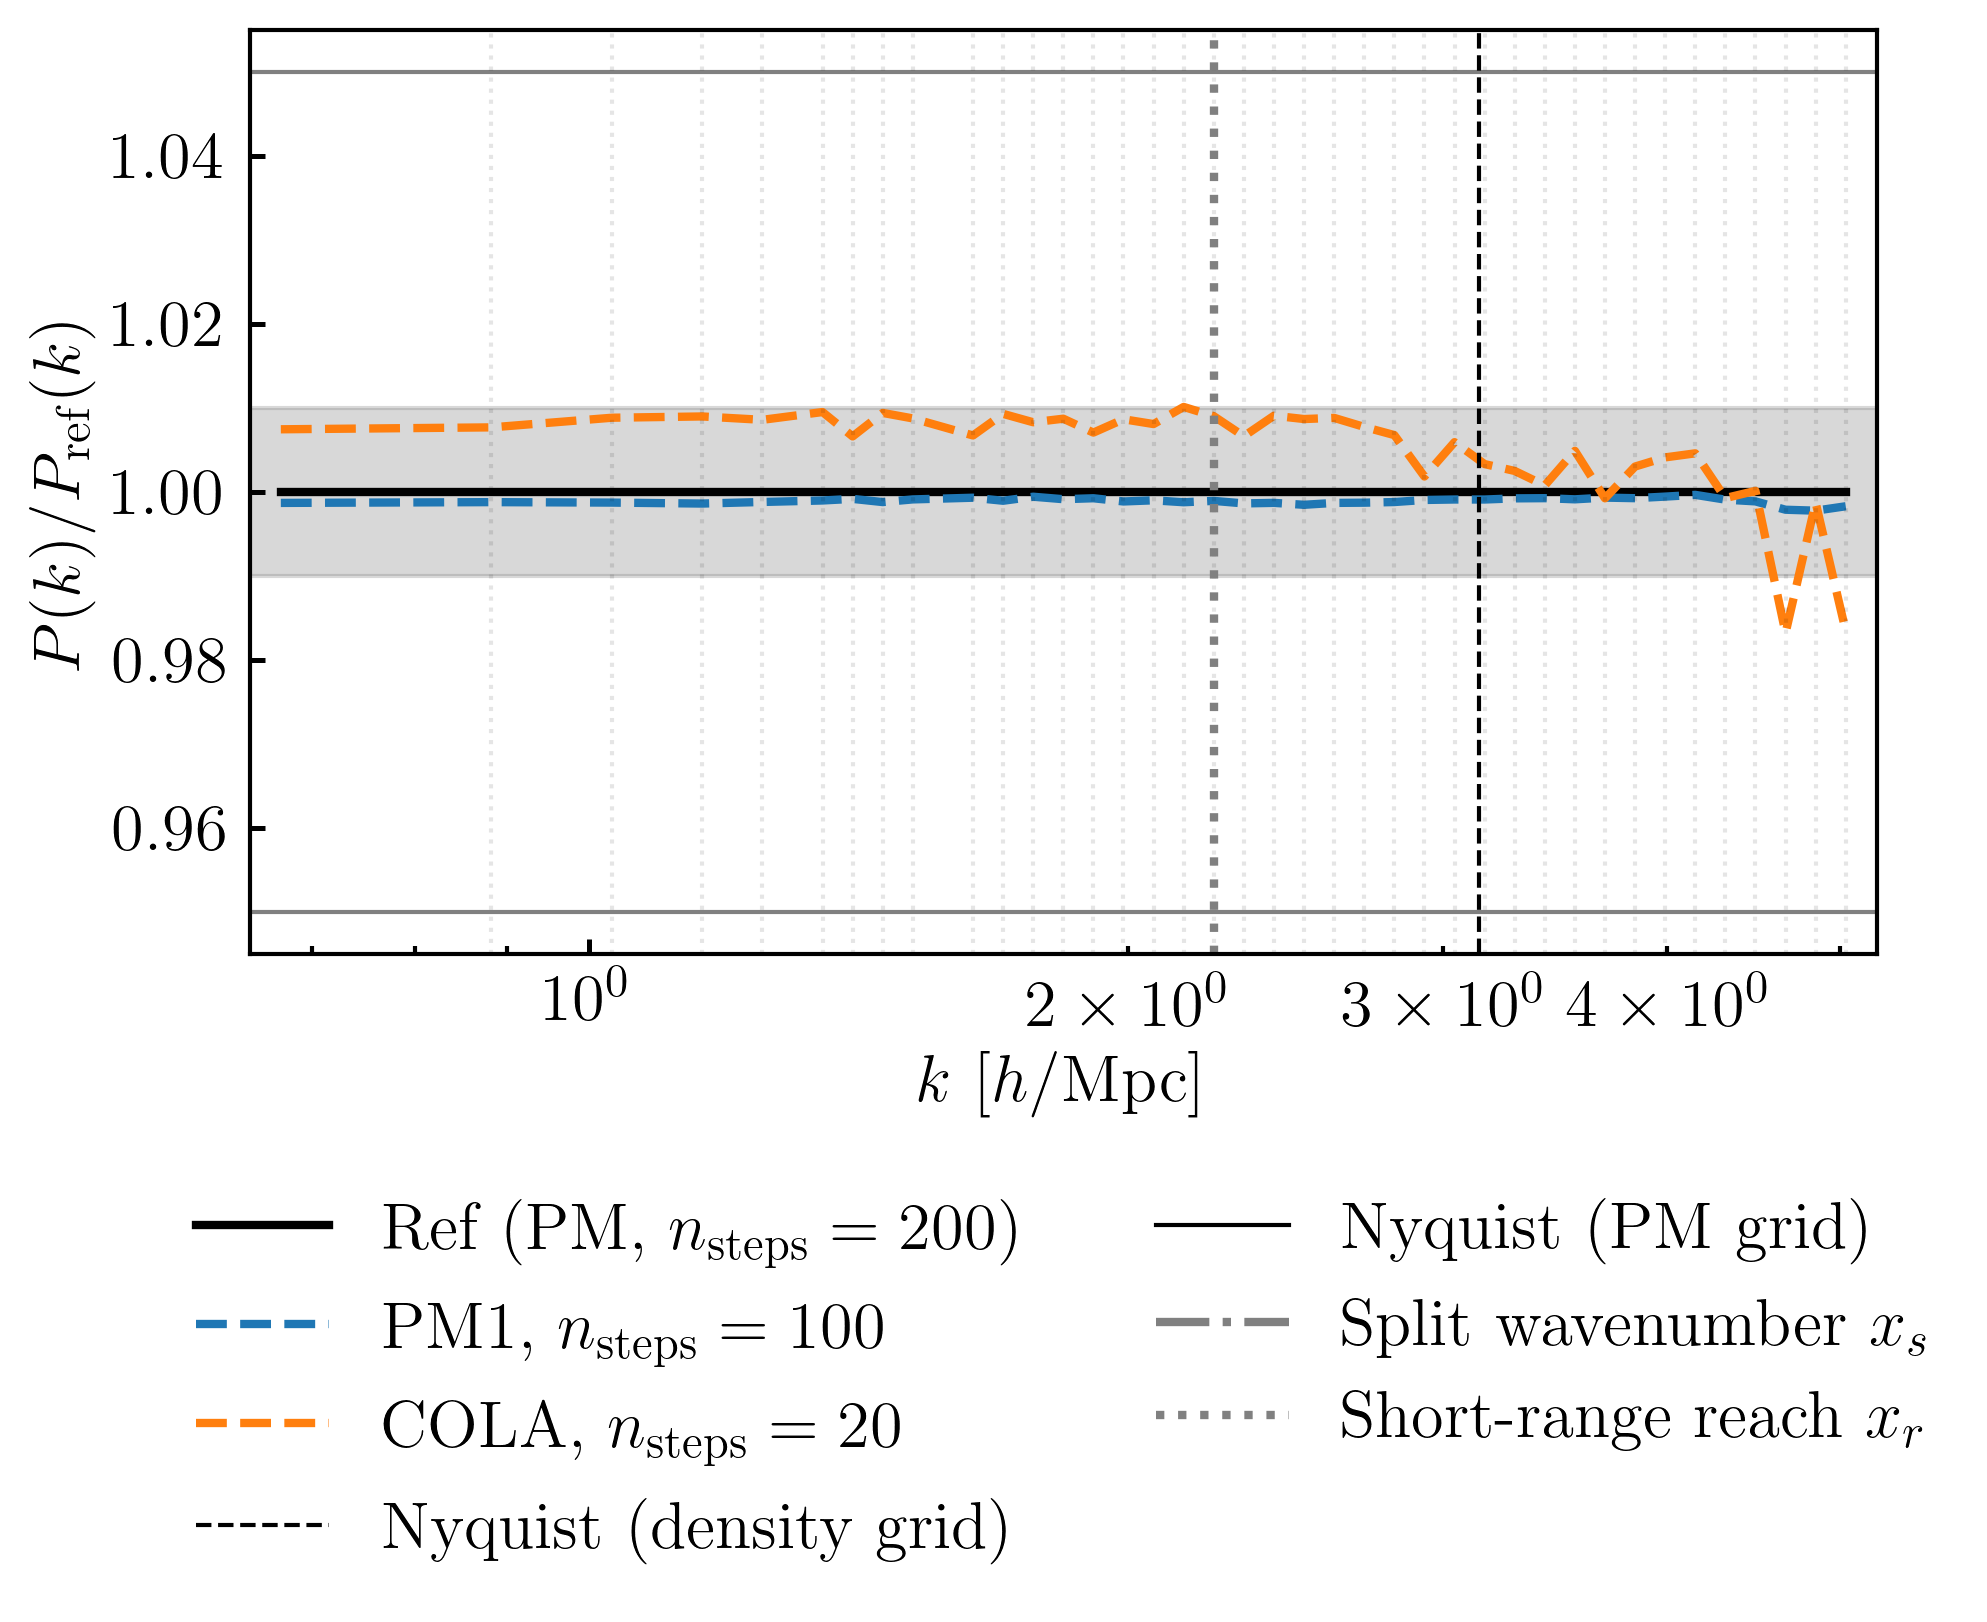

In [17]:
Pk_ref = Pk_PMref

fig, ax = plt.subplots(figsize=(7, 4))

ax.set_xscale("log")
k = G.k_modes[1:]
kmin, kmax = k.min(), k.max()
print(f"kmin = {kmin}, kmax = {kmax}")
log_pad = 0.02
log_k_min = np.log10(kmin)
log_k_max = np.log10(kmax)
log_range = log_k_max - log_k_min
xlim_min = 10 ** (log_k_min - log_pad * log_range)
xlim_max = 10 ** (log_k_max + log_pad * log_range)

plt.xlim(xlim_min, xlim_max)
# ax.set_ylim([0.2, 1.8])
dark_grey_bnd = 0.01
light_grey_bnd = 0.05

label_ref = f"Ref (PM, $n_\\mathrm{{steps}}={nsteps_pmref}$)"

ax.plot([kmin, kmax], [1, 1], color="black", linestyle="-", label=label_ref)
# ax.plot(k, Pk_LPT / Pk_ref, label="2LPT", linestyle="--")
fields_to_plot = [
    ("PM1", Pk_PM1),
    # ("PM2", Pk_PM2),
    ("COLA", Pk_COLA),
]
for field_name, Pk in fields_to_plot:
    label = f"{field_name}, $n_\\mathrm{{steps}}={eval(f'nsteps_{field_name.lower()}')}$"
    ax.plot(k, Pk / Pk_ref, label=label, linestyle="--")

ax.axhspan(1 - dark_grey_bnd, 1 + dark_grey_bnd, color="grey", alpha=0.3)
ax.axhline(1 - light_grey_bnd, color="grey", linestyle="-", linewidth=1)
ax.axhline(1 + light_grey_bnd, color="grey", linestyle="-", linewidth=1)

for i in range(1, len(k)):
    ax.axvline(k[i], color="black", linestyle=":", linewidth=1, alpha=0.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)

# Characteristic vertical reference scales
nyquist = np.pi * N / L
nyquist_PM = np.pi * Npm / L
epsilon = 0.03 * L / Np
particle_length = 2*epsilon
xs = 1.25 * L / Npm
xr = 4.5 * xs
particle_wavenumber = 2*np.pi / particle_length
xs_inv = 2*np.pi / xs
xr_inv = 2*np.pi / xr
line1 = ax.axvline(x=nyquist, color="black", linestyle="--", lw=1, label="Nyquist (density grid)")
line1 = ax.axvline(x=nyquist_PM, color="black", linestyle="-", lw=1, label="Nyquist (PM grid)")
# line2 = ax.axvline(x=particle_wavenumber, color="gray", linestyle="--", lw=2, label=r"Particle wavenumber $2\epsilon$")
line3 = ax.axvline(x=xs_inv, color="gray", linestyle="-.", lw=2, label=r"Split wavenumber $x_s$")
line4 = ax.axvline(x=xr_inv, color="gray", linestyle=":", lw=2, label=r"Short-range reach $x_r$")
print(f"Nyquist (density grid): {nyquist:.2f} h/Mpc")
print(f"Nyquist (PM grid): {nyquist_PM:.2f} h/Mpc")
print(f"Particle wavenumber: {particle_wavenumber:.2f} h/Mpc")
print(f"Split wavenumber: {xs_inv:.2f} h/Mpc")
print(f"Short-range reach: {xr_inv:.2f} h/Mpc")

empty_patch = mpatches.Patch(color="none", label="")
handles, labels = plt.gca().get_legend_handles_labels()
# handles = [empty_patch, *handles]
# labels = ["", *labels]
plt.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.2),
    fontsize=fs,
    frameon=False,
)
fig.savefig(
    simdir + "power_spectra.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + "power_spectra.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

### Force exerted by particles on other particles

In [18]:
if force_diagnostic:
    r1, fmag1, _ = load_force_diagnostic(OutputForceDiagnostic_pmref)
    r4, fmag4, _ = load_force_diagnostic(OutputForceDiagnostic_cola)
    r2, fmag2, _ = load_force_diagnostic(OutputForceDiagnostic_spm)
    r3, fmag3, _ = load_force_diagnostic(OutputForceDiagnostic_p3m1)

    rr = np.array([r1, r4, r2, r3], dtype=object)
    ff = np.array([fmag1, fmag4, fmag2, fmag3], dtype=object)
    ll = np.array(["PM", "COLA", "sPM", "P3M"])

    ix = [0, 1, 2, 3]

    Newton_prefactor = (L / Np)**3 / (4*np.pi)
    print(f"Newton prefactor = {Newton_prefactor:.2e}")
    plot_force_distance_comparison(rr=rr[ix], ff=ff[ix], ll=ll[ix], L=L, Np=Np, Npm=Npm, a=Newton_prefactor, title="Particle's contributions to total force", save_path=simdir + "force_diagnostic_comparison.png")